During this session we'll make use of the pathlib library. It provides an object-oriented approach to represent filesystem paths and works across operating systems.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Custom problems

## Calculating ETo

The code below provides some ideas for implementing an evapotranspiration module as part of a water balance model. The real version of this code should use the Penman-Monteith equation, but to simplify the code example, the Hargreaves equation is demonstrated here instead.

The code could be organised in a class (called `ETModel`) that loads the required data, calculates ETo and creates a multi-graph figure of the data and the calculated ETo.

In [6]:
class ETModel:
    def __init__(self, workspace="et_model"):
        """_summary_

        Parameters
        ----------
        workspace : str
            Name of the folder with the model data. Also used for output.
        """
        self.df = None
        self.workspace = workspace

    def load_data(self, xl_fname):
        """_summary_

        Parameters
        ----------
        xl_fname : str
            Name of the Excel file with the input data.
        """        
        try:
            fpath = Path(self.workspace, xl_fname)
            self.df = pd.read_excel(
                fpath,
                sheet_name="Climate input template",
                skiprows=3,
                index_col=0,
                parse_dates=True,
            )
        except:
            print("Something went wrong...")

    def ET_Hargreaves(self):
        
        """
        This method calculates the reference ET using the Hargreaves equation. See:
        https://pyeto.readthedocs.io/en/latest/_modules/pyeto/fao.html#hargreaves
        """
        try:
            tmin = self.df["Tmin"]
            tmax = self.df["Tmax"]
            tmean = (tmin + tmax) / 2.
            et_rad = self.df["Radn"]

            self.df["ETo"] = 0.0023 * (tmean + 17.8) * (tmax - tmin) ** 0.5 * 4.08e-4 * et_rad
        except:
            print("Something went wrong...")

    def plot(self):
        """
        This method plots the input and output data.
        """        
        fig, axs = plt.subplots(nrows=3, figsize=(10, 8))
        ax = axs[0]
        ax.plot(self.df.index, self.df["Tmax"], label="Max temp (C)")
        ax.plot(self.df.index, self.df["Tmin"], label="Min temp (C)")
        ax.set_ylabel("Temperature (\u00B0C)")

        ax = axs[1]
        ax.bar(self.df.index, self.df["Rain"], width=self.df["Durn"])
        ax.set_ylabel("Daily rainfall (m)")

        ax = axs[2]
        ax.bar(self.df.index, self.df["ETo"] / 1000, width=1)
        ax.set_ylabel("ETo (m)")
        ax.set_xlabel("Year")

    def save_results(self, fname="et_results.csv"):
        """
        This method saves the DataFrame with the calculated evaporation rates
        """        
        Path(self.workspace, "results").mkdir(exist_ok=True)
        fpath = Path(self.workspace, "results", fname)
        self.df.to_csv(fpath)


The various class methods can be called by initializing an instance of `ETModel`.

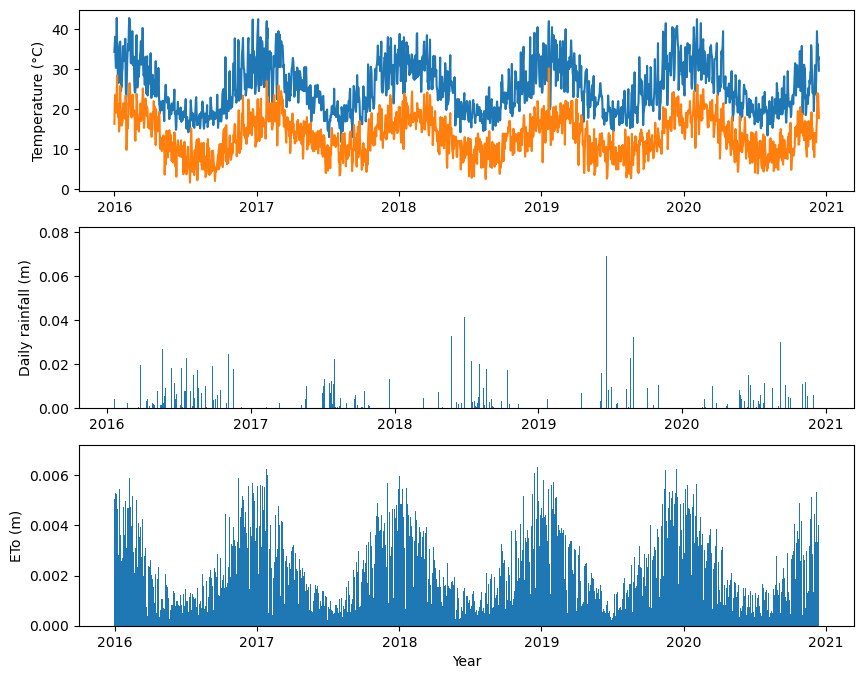

In [8]:
et_model = ETModel()
et_model.load_data("Example dataset.xlsx")
et_model.ET_Hargreaves()
et_model.plot()
et_model.save_results()

## Pulling model parameters from an Excel workbook

Various  model parameters can be extracted from the Excel file in the following way, for example, the soil albedo.

In [15]:
fpath = Path("et_model", "Example dataset.xlsx")
dfv = pd.read_excel(
    fpath,
    sheet_name="Veg data input",
    skiprows=1,
    header=None,
    names=["Parameter", "Pasture", "Wetland"],
    usecols="E,F,N",
    index_col=0,
)

for col in dfv.columns:
    row_name = "One minus Albedo of Soil"
    soil_albedo = 1 - dfv.loc[row_name, col]
    print(f"The soil_albedo of {col} is {soil_albedo}.")

The soil_albedo of Pasture is 0.15000000000000002.
The soil_albedo of Wetland is 0.30000000000000004.


It is also possible to combine the data from different work sheets. The following code example reads the soil parameters in the worksheet called 'BW table (soil generation)'. It then uses the numerical code for the soil type in the soil profile information (which is in the worksheet 'Node table (soil)') to assign the saturated hydraulic coductivity to each node of the soil profile model. The result is plotted using the Matplotlib function `step`.

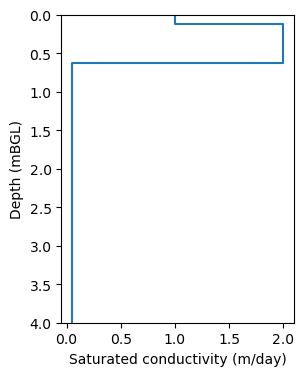

In [16]:
dfs = pd.read_excel(
    fpath,
    sheet_name="BW table (soil generation)",
    skiprows=[r for r in range(14) if r not in [2, 3, 7, 11]],
    usecols="C:G",
)

dfn = pd.read_excel(
    fpath,
    sheet_name="Node table (soil)",
    skiprows=1,
    usecols="C:G",
)

col_name = "Ks"
dfn[col_name] = np.nan
for i, row in dfs.iterrows():
    idx = dfn["Soil type indicator"] - 1 == i
    dfn.loc[idx, col_name] = row[col_name]

fig, ax = plt.subplots(figsize=(3, 4))
ax.step(dfn[col_name], dfn["Depth(mBGL)"])
ax.set_xlabel("Saturated conductivity (m/day)")
ax.set_ylabel("Depth (mBGL)")
ax.set_ylim(dfn["Depth(mBGL)"].iloc[-1], dfn["Depth(mBGL)"].iloc[0]);

***Exercise***: Expand the previouse example by adding a second graph that shows the residual water content ('thetar') as a function of depth.

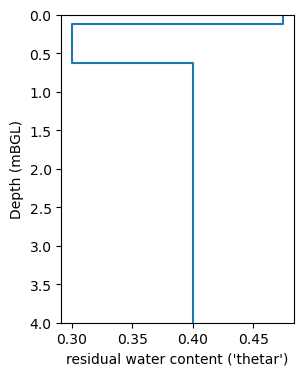

In [17]:
col_name = "Theta.s"
dfn[col_name] = np.nan
for i, row in dfs.iterrows():
    idx = dfn["Soil type indicator"] - 1 == i
    dfn.loc[idx, col_name] = row[col_name]

fig, ax = plt.subplots(figsize=(3, 4))
ax.step(dfn[col_name], dfn["Depth(mBGL)"])
ax.set_xlabel("residual water content ('thetar')")
ax.set_ylabel("Depth (mBGL)")
ax.set_ylim(dfn["Depth(mBGL)"].iloc[-1], dfn["Depth(mBGL)"].iloc[0]);

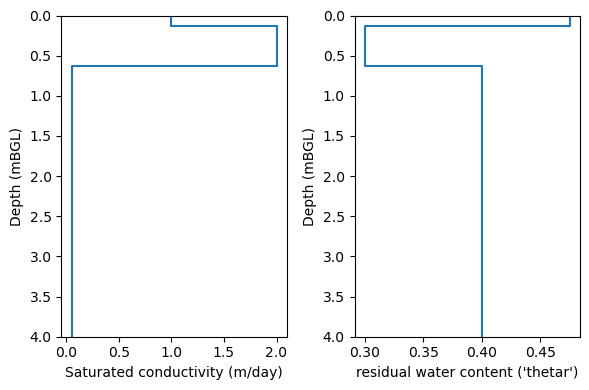

In [19]:
col_name0 = "Ks"
dfn[col_name0] = np.nan
col_name1 = "Theta.s"
dfn[col_name1] = np.nan
for i, row in dfs.iterrows():
    idx = dfn["Soil type indicator"] - 1 == i
    dfn.loc[idx, col_name0] = row[col_name0]
    dfn.loc[idx, col_name1] = row[col_name1]

fig, axs = plt.subplots(ncols=2, figsize=(6, 4))
for i, col_name in enumerate([col_name0, col_name1]):
    ax = axs[i]
    ax.step(dfn[col_name], dfn["Depth(mBGL)"])
    if i == 0:
        ax.set_xlabel("Saturated conductivity (m/day)")
    else:
        ax.set_xlabel("residual water content ('thetar')")
    ax.set_ylabel("Depth (mBGL)")
    ax.set_ylim(dfn["Depth(mBGL)"].iloc[-1], dfn["Depth(mBGL)"].iloc[0]);
fig.tight_layout()

## Converting a number of csv files to a different format

The code below shows how to iterate over a number of comma-separated values files in a folder and convert each to a different format. First, let's create a list with all csv files in the folder csv_files. We use the `glob` method of the `Path` object to list all the csv files.

In [3]:
csv_fnames = Path('csv_files').glob('*.csv')

We can loop over the file names in the list, read their contents and save them in the desired format.

In [4]:
# Use Path to create subfolder 'txt_files' if it does not exist yet
Path('txt_files').mkdir(exist_ok=True)

for input_fname in csv_fnames:
    df = pd.read_csv(
      input_fname, 
      index_col=0,
      parse_dates=True,
    )

    output_fname = Path(str(input_fname).replace("csv", "txt"))

    df.to_csv(
        output_fname, 
        date_format="%d/%m/%Y", 
        sep='\t',
    )

The data now appear in the file in the desired format. But the goal is to also create a preamble with three lines containing some additional information. This is possible by opening the txt files in 'append' mode, then writing the preamble lines first, and then use the `to_csv` method to write the acutal data. Note that the file must be closed at the end. Because the file is openend in append mode, the original txt files must be deleted first (otherwise they'd get longer and longer upon repeated use of the code).

In [7]:
# Second attempt, with preamble
csv_fnames = Path('csv_files').glob('*.csv')

# Delete any existing txt files
txt_fnames = Path('txt_files').glob('*.txt')
for txt_fname in txt_fnames:
    txt_fname.unlink()

for input_fname in csv_fnames:
    
    # Read the original csv file
    df = pd.read_csv(
      input_fname, 
      index_col=0,
      parse_dates=True,
    )

    # Open output file as text file
    output_fname = Path(str(input_fname).replace("csv", "txt"))
    f = open(output_fname, 'a')
    
    # Write preamble
    
    f.write('012345 Station name\n')
    f.write('Calculated value\n')
    f.write('m3/hr\n')
    
    # Export DataFrame
    df.to_csv(
        f, 
        date_format="%d/%m/%Y", 
        sep='\t',
        header=False,
        lineterminator='\n',
    )
    
    # Close the file
    f.close()


## Downloading data from a REST API

In session 4, Onno demonstrated <A href="https://github.com/ArtesiaWater/hydropandas">Hydropandas</A>. It pulls online data into a Pandas DataFrame. A similar library was developed by Kent Inverarity for the groundwater data in the South Australian WaterConnect database, see
<A href="https://github.com/kinverarity1/python-sa-gwdata">https://github.com/kinverarity1/python-sa-gwdata</A>. The key command behind both libraries is the `get` method of the `requests` package, which will attempt to retrieve data from a specified source. The request is made by passing an url with a specifc stucture, which is defined by the application programming interface (API) of the service that is being queried. Several protocols exists, with the most common one today being the representational state transfer architectural style (REST), and an API that conforms to this standard is called a RESTful API.

Without providing any more technical details, let's just try to see how this works. Click the following link and observe the information that appears in your web browser.

<A href="https://www.waterconnect.sa.gov.au/_layouts/15/dfw.sharepoint.wdd/WDDDMS.ashx/GetObswellNumberSearchData?OBSNUMBER=WLG051">https://www.waterconnect.sa.gov.au/_layouts/15/dfw.sharepoint.wdd/WDDDMS.ashx/GetObswellNumberSearchData?OBSNUMBER=WLG051</A>

The data obtained appear in the form of a table and it can be seen that there are several fields. This is not very useful yet, but it gives you an idea of the information that is sent when you use the `get` method. If you look at the above url, it is possible to recognise three parts:
 * a base url: https://www.waterconnect.sa.gov.au/_layouts/15/dfw.sharepoint.wdd/WDDDMS.ashx/
 * a command: 'GetObswellNumberSearchData'
 * a section with parameters for the command: 'OBSNUMBER=WLG051'

From this we can infer that this url requests to search data based on the Obswel number, which in this case is specified to be WLG051 (not entirely coincidentally, this is the monitoring bore right next to the farm dam).

Now let's do this in Python using the `get` method. We create a variable `url`, which combines the base url and the command and we pass the command parameters as a dictionary.

In [8]:
import requests

base_url = "https://www.waterconnect.sa.gov.au/_layouts/15/dfw.sharepoint.wdd/WDDDMS.ashx/"
url = base_url + "GetObswellNumberSearchData"
rest_params = {"OBSNUMBER": "WLG051"}

response = requests.get(url, params=rest_params)

The returned data are stored in `response`. This is an object that contains information about the request and, if the request was successful, the data in JSON format (note that this differs depending on the API, other services may use a different format, e.g. csv). JSON is shorthand for JavaScript Object Notation and is a common data-interchange format. Although it is intended to be readable for humans, it is not as convenient as a DataFrame, so the next code cell converts the data to a DataFrame called `df`. 

In [9]:
data = response.json()
df = pd.json_normalize(response.json())

Inspecting the DataFrame in the variable explorer shows that it has a column 'DHNO', which stands for drillhole number. We can use this number in combination with the API command 'GetWaterLevelDetails' to get the water level time series for this well.

In [10]:

dhno = df["DHNO"]
url = base_url + "GetWaterLevelDetails"
rest_params = {"DHNO": dhno}

response = requests.get(url, params=rest_params)

Once again, we can convert the JSON data to a DataFrame. The data in the column 'OBS_DATE' can be converted to a datetime format, and be used as the index of the DataFrame.

In [11]:
data = response.json()
df = pd.json_normalize(response.json())
df.index = pd.to_datetime(df["OBS_DATE"])

Plotting the data is then a breeze of course...

Text(0, 0.5, 'RSWL')

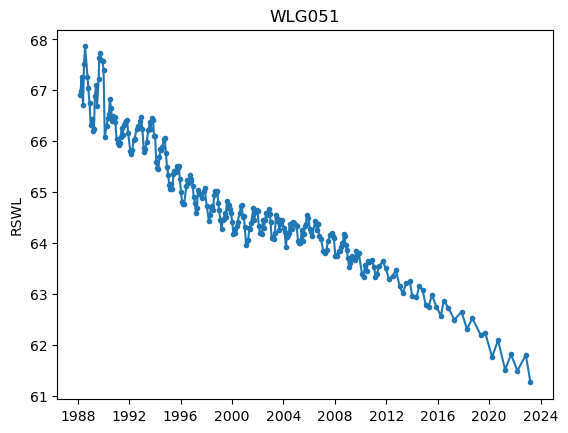

In [12]:
fig, ax = plt.subplots()
ax.plot(df.index, df["RSWL"], '.-')
ax.set_title("WLG051")
ax.set_ylabel("Year")
ax.set_ylabel("RSWL")

The examples above demonstrate the use of the `get` method. Libraries like <A href="https://github.com/kinverarity1/python-sa-gwdata">python-sa-gwdata</A> and <A href="https://github.com/ArtesiaWater/hydropandas">Hydropandas</A> wrap Python code around this method to provide a user-friendly way to obtain data from a database. If you work with chemicals then <A href="https://pubchempy.readthedocs.io/en/latest/">PubChemPy</A> is another interesting package to look at, as it allows you to access the data in the <A href="https://pubchem.ncbi.nlm.nih.gov/">PubChem</A> database. More RESTful APIs exist, and their number is growing.

## PyQGIS 
QGIS (and ArcGIS) offers Python support via the QGIS Python API. Extensive documentation is provided <A href="https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/index.html#">here</A>. The example below will use GeoPandas to create a shapefile of some data downloaded from  WaterConnect. The shapefile will be imported into QGIS and PyQGIS will be used to create three separate layers showing the boreholes with chemistry, water (level) and salinity data, respectively. The PyQGIS interface will also be used to set a different marker symbol colour for each of the three layers.

Let's start by using the WaterConnect API to download the availabe boreholes in a rectangular area near McLarenVale, SA.

In [13]:
url = base_url + "GetGridData"
rest_params = {"Box": "-35.25,138.55,-35.20,138.6"}
response = requests.get(url, params=rest_params)


# Convert to DataFrame
data = response.json()
df = pd.json_normalize(response.json())

With Geopandas, the DataFrame can be converted to a shapefile with just a few lines of code. First the data in the columns 'LON' and 'LAT' will be used to create the coordinate data. Together with the DataFrame `df` the coordinate data in `lat_long_coordinates` is used to create a GeoDataFrame (note that the EPSG code 4326 is for lat/long coordinates based on the World Geodetic System 1984 ensemble (WSG84)). The method `to_file` saves the shapefile to disk, and the `mkdir` call ensures that the subdirectory 'shp' exists.

In [14]:
import geopandas as gpd

lat_long_coordinates = gpd.points_from_xy(df["LON"], df["LAT"])
gdf = gpd.GeoDataFrame(
    df, 
    geometry=lat_long_coordinates, 
    crs="EPSG:4326",
)

Path('shp').mkdir(exist_ok=True)
gdf.to_file("shp/borehole_data.shp")

C:\Users\PRI258\AppData\Local\Temp\ipykernel_17952\420095196.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("shp/borehole_data.shp")


The code below will only work inside the QGIS Python editor (as will be demonstrated during the session). Note that the information on the object model for QGIS is extensive. For example, the documentation for a map layer object can be found <A href="https://api.qgis.org/api/classQgsMapLayer.html">here</A> and there are many, many more (see <A href="https://api.qgis.org/api/modules.html">https://api.qgis.org/api/modules.html</A>).

In [ ]:
current_project = QgsProject.instance()

layer = current_project.mapLayersByName('borehole_data')[0]

field_names = ["CHEM", "WATER", "SAL"]

for field_name in field_names:
    new_layer = layer.clone()
    new_layer.setName(f'{field_name}_data')
    new_layer.setSubsetString(f'"{field_name}" = \'Y\'')
    current_project.addMapLayer(new_layer)

colors = ["red", "green", "blue"]    
for field_name, color in zip(field_names, colors):
    layer = current_project.mapLayersByName(f'{field_name}_data')[0]
    layerRenderer= layer.renderer()
    mSingleRenderer = QgsSingleSymbolRenderer.convertFromRenderer(layerRenderer)

    new_sym = QgsMarkerSymbol.createSimple({"color": color})
    mSingleRenderer.setSymbol(new_sym)
    layer.setRenderer(mSingleRenderer)